In [1]:
"""
SHAP Interaction Values using 

From: Maya Thompson (City Mobility Manager)
To: Data Science Team
Subject: Understanding Bike-Share Demand Drivers

Hi Justin,

We’ve been looking at our bike-share ridership numbers and while we have some ideas about what drives

demand (like weather, time of day, and weekends), the team keeps running into confusing situations where things don’t add up.

On hot weekends, demand seems to spike — but not on hot weekdays.

Surge pricing seems to help sometimes, but not always.

Riders complain that even a small chance of rain kills demand, especially in humid weather.

Right now, our marketing and ops teams don’t know which combinations of factors matter most.

Could you build a quick analysis to show us not just the individual effects of these features,

but also how they interact with each other?

Ideally, we’d like some visuals we can share in our next planning meeting that

highlight the strongest pairs of features influencing ridership.

Thanks so much,
Maya

✍ **Author**: Justin Wall
📅 **Date**: 02/13/2025
"""

'\nSHAP Interaction Values using \n\nFrom: Maya Thompson (City Mobility Manager)\nTo: Data Science Team\nSubject: Understanding Bike-Share Demand Drivers\n\nHi Justin,\n\nWe’ve been looking at our bike-share ridership numbers and while we have some ideas about what drives\n\ndemand (like weather, time of day, and weekends), the team keeps running into confusing situations where things don’t add up.\n\nOn hot weekends, demand seems to spike — but not on hot weekdays.\n\nSurge pricing seems to help sometimes, but not always.\n\nRiders complain that even a small chance of rain kills demand, especially in humid weather.\n\nRight now, our marketing and ops teams don’t know which combinations of factors matter most.\n\nCould you build a quick analysis to show us not just the individual effects of these features,\n\nbut also how they interact with each other?\n\nIdeally, we’d like some visuals we can share in our next planning meeting that\n\nhighlight the strongest pairs of features influenc

In [ ]:
# ================================= #
# Generate Fake Bike Share Data     #
# ================================= #
#%%
# Regenerate with a small fix (use np.clip instead of ndarray.clip to avoid Index edge-cases)
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

n_days = 50
hours_per_day = 24
n = n_days * hours_per_day
start = pd.Timestamp("2024-06-01")

timestamps = pd.date_range(start, periods=n, freq="H")
hour_of_day = timestamps.hour
day_of_week = timestamps.dayofweek
is_weekend = ((day_of_week >= 5).astype(int))

daily_base = rng.normal(72, 8, size=n_days)
diurnal = 10 * np.sin(2 * np.pi * (hour_of_day - 15) / 24)
temp_F = np.repeat(daily_base, hours_per_day) + diurnal + rng.normal(0, 2.0, n)
temp_F = np.clip(temp_F, 35, 98)

humidity_base = rng.normal(60, 12, size=n) + 10 * np.cos(2 * np.pi * (hour_of_day) / 24)
humidity_base = np.clip(humidity_base, 20, 100)

rain_events = rng.binomial(1, 0.15, size=n_days)
rain_prob = np.repeat(rain_events, hours_per_day) * rng.beta(2, 5, size=n)
rain_prob = np.maximum(rain_prob, rng.binomial(1, 0.03, size=n) * rng.uniform(0.1, 0.6, size=n))

wind_mph = np.clip(rng.gamma(3, 2, size=n), 0, 30)

base_surge = (hour_of_day >= 17).astype(int) * rng.binomial(1, 0.4, size=n)
weekend_surge = is_weekend * rng.binomial(1, 0.30, size=n)
surge_pricing_on = np.clip(base_surge + weekend_surge, 0, 1)

holiday_days = rng.choice(np.arange(n_days), size=max(1, int(0.05 * n_days)), replace=False)
holiday = np.isin(np.repeat(np.arange(n_days), hours_per_day), holiday_days).astype(int)

near_park = np.ones(n, dtype=int)

humidity_pct = np.clip(humidity_base + 35 * (rain_prob > 0.4), 20, 100)

commute_wave = (
    18 * np.exp(-0.5 * ((hour_of_day - 8) / 2.5) ** 2) +
    28 * np.exp(-0.5 * ((hour_of_day - 18) / 3.0) ** 2)
)

beta_temp = 0.9 * np.maximum(temp_F - 50, 0)
beta_humidity = -0.08 * (humidity_pct - 60)
beta_wind = -0.7 * np.maximum(wind_mph - 8, 0)
beta_rain = -40 * rain_prob
beta_weekend = 10 * is_weekend
beta_surge = 6 * surge_pricing_on
beta_holiday = -8 * holiday

interaction_temp_weekend = 0.45 * (temp_F - 55) * is_weekend
interaction_surge_evening = 12 * surge_pricing_on * (hour_of_day >= 17)
interaction_rain_humid = -25 * rain_prob * np.clip((humidity_pct - 60) / 40, 0, 1)
interaction_wind_cold = -0.9 * wind_mph * (np.clip(60 - temp_F, 0, 20) / 20)

mu = (
    35 + commute_wave
    + beta_temp + beta_humidity + beta_wind + beta_rain + beta_weekend + beta_surge + beta_holiday
    + interaction_temp_weekend + interaction_surge_evening + interaction_rain_humid + interaction_wind_cold
)

epsilon = rng.normal(0, 6, size=n)
rides = np.clip(np.round(mu + epsilon), 0, None).astype(int)

df = pd.DataFrame({
    "timestamp": timestamps,
    "rides": rides,
    "temp_F": np.round(temp_F, 1),
    "humidity_pct": np.round(humidity_pct, 0).astype(int),
    "wind_mph": np.round(wind_mph, 1),
    "rain_prob": np.round(rain_prob, 3),
    "is_weekend": is_weekend,
    "hour_of_day": hour_of_day,
    "near_park": near_park,
    "surge_pricing_on": surge_pricing_on,
    "holiday": holiday
})

path = "C:\\Users\\wallj\\DS_Projects\\Datasets\\bike_share_hourly.csv"
df.to_csv(path, index=False)

# import caas_jupyter_tools as cj
# cj.display_dataframe_to_user("Bike-share synthetic dataset (hourly)", df.head(25))

# path

df.head()

#%%

'H' is deprecated and will be removed in a future version, please use 'h' instead.


,timestamp,rides,temp_F,humidity_pct,wind_mph,rain_prob,is_weekend,hour_of_day,near_park,surge_pricing_on,holiday
0,2024-06-01 00:00:00,84,82.1,82,12.5,0.0,1,0,1,0,0
1,2024-06-01 01:00:00,95,80.7,88,8.1,0.0,1,1,1,0,0
2,2024-06-01 02:00:00,80,74.1,59,16.6,0.0,1,2,1,1,0
3,2024-06-01 03:00:00,60,73.8,71,4.0,0.0,1,3,1,0,0
4,2024-06-01 04:00:00,92,70.9,56,4.3,0.0,1,4,1,0,0


In [15]:
# =============================
# 1) SETUP & LOAD DATA
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
import shap

df = pd.read_csv("C:\\Users\\wallj\\DS_Projects\\Datasets\\bike_share_hourly.csv", parse_dates=["timestamp"])
print("Rows, Cols:", df.shape)
df.head()

Rows, Cols: (1200, 11)


,timestamp,rides,temp_F,humidity_pct,wind_mph,rain_prob,is_weekend,hour_of_day,near_park,surge_pricing_on,holiday
0,2024-06-01 00:00:00,84,82.1,82,12.5,0.0,1,0,1,0,0
1,2024-06-01 01:00:00,95,80.7,88,8.1,0.0,1,1,1,0,0
2,2024-06-01 02:00:00,80,74.1,59,16.6,0.0,1,2,1,1,0
3,2024-06-01 03:00:00,60,73.8,71,4.0,0.0,1,3,1,0,0
4,2024-06-01 04:00:00,92,70.9,56,4.3,0.0,1,4,1,0,0


Dataset is at the hourly level with count of rides, weather, day, location, pricing

In [16]:
# =============================
# 2) FEATURE PREP & TRAIN/TEST SPLIT
# -----------------------------
# What: Select features, split into train and test.
# Why: Keep modeling honest and allow quick RMSE check.
# =============================
target = "rides"
features = ["temp_F",
            "humidity_pct",
            "wind_mph",
            "rain_prob",
            "is_weekend",
            "hour_of_day",
            "near_park",
            "surge_pricing_on",
            "holiday"]

X = df[features].copy()
y = df[target].values

# Train/test split (time-aware optional; here we do a random split for simplicity)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (960, 9)  Test: (240, 9)


In [17]:
# =============================
# 3) TRAIN A COMPACT TREE MODEL (LightGBM)
# -----------------------------
# What: Fit a small, readable LightGBM regressor.
# Why: Tree ensembles naturally capture interactions; SHAP has exact interaction values for trees.
# =============================
lgbm = lgb.LGBMRegressor(
    n_estimators=400,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    force_row_wise=True,
    random_state=42
).fit(X_train, y_train)

# Quick performance check
preds_test = lgbm.predict(X_test)
rmse = mean_squared_error(y_test, preds_test)
print(f"Test RMSE: {rmse:.2f}")

[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 8
[LightGBM] [Info] Start training from score 73.415625
Test RMSE: 56.58


In [18]:
# =============================
# 4) SHAP EXPLAINER & INTERACTION VALUES
# -----------------------------
# What: Build a SHAP TreeExplainer, compute SHAP values and SHAP interaction values.
# Why: Interaction values reveal how PAIRS of features push predictions up/down together.
# =============================
# Compatibility patch for SHAP expecting deprecated numpy types
explainer = shap.TreeExplainer(lgbm)
# X = X.sample(n=min(600, len(X)), random_state=1)
interaction_values = explainer.shap_interaction_values(X)
# print("interaction_values shape:", np.array(interaction_values).shape)

# Subsample for speed
# rng = np.random.RandomState(0)
# sample_idx = rng.choice(len(X), size=min(800, len(X)), replace=False)
# X = X.iloc[sample_idx]

# Compute SHAP and interaction values
shap_values = explainer.shap_values(X)
# interaction_values = explainer.shap_interaction_values(X)

print("X shape:", X.shape)
print("interaction_values shape:", np.array(interaction_values).shape)

X shape: (1200, 9)
interaction_values shape: (1200, 9, 9)


Sampling is recommended but it's just not doing much for me here computationally so I'm ditching it, funny because it was running it twice...

In [19]:
# =============================
# 5) RANK GLOBAL INTERACTIONS
# -----------------------------
# What: Aggregate mean |interaction value| for each pair to find the strongest effects.
# Why: Provides a simple "top pairs" table for stakeholders.
# =============================
feat_names = X.columns.tolist() # list of feature names
iv = np.abs(np.array(interaction_values))  # [n, F, F]
mean_abs_iv = iv.mean(axis=0)              # [F, F]

# Get upper triangle pairs (i < j) to avoid duplicates
pairs = []
for i in range(len(feat_names)):
    for j in range(i+1, len(feat_names)):
        pairs.append((feat_names[i], feat_names[j], mean_abs_iv[i, j]))

top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:8]
top_pairs_df = pd.DataFrame(top_pairs, columns=["feature_i", "feature_j", "mean_abs_interaction"])
top_pairs_df["mean_abs_interaction"] = top_pairs_df["mean_abs_interaction"].round(3)
top_pairs_df

,feature_i,feature_j,mean_abs_interaction
0,temp_F,hour_of_day,1.004
1,hour_of_day,surge_pricing_on,0.957
2,temp_F,is_weekend,0.540
3,temp_F,wind_mph,0.525
4,temp_F,humidity_pct,0.503
5,humidity_pct,wind_mph,0.457
6,is_weekend,hour_of_day,0.403
7,humidity_pct,hour_of_day,0.393


SHAP gives you a value for each obervation in the dataset, so we want the absolute value so we can only focus on magnitude, and then the mean so we can average across all observations.

SHAP values are in the same units as the target, so temp + hour changes rides per hour by 1

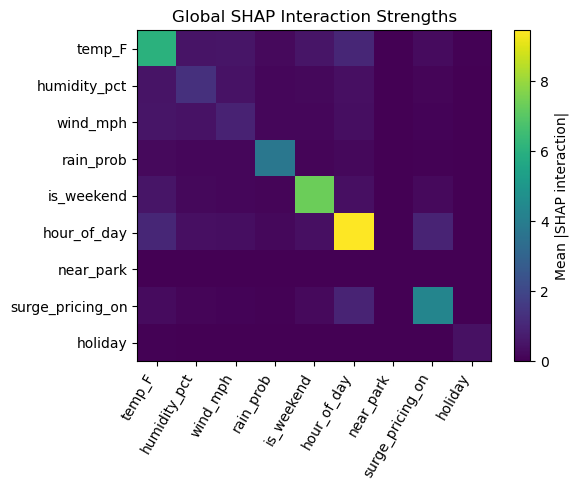

In [20]:
# =============================
# 6) VISUALIZE: INTERACTION HEATMAP (GLOBAL VIEW)
# -----------------------------
# What: Heatmap of mean |interaction values| across all feature pairs.
# Why: Quick scan to see which pairs the model relies on most.
# Notes: Using pure matplotlib per instructions (no seaborn).
# =============================
fig = plt.figure(figsize=(6,5))
plt.imshow(mean_abs_iv, aspect="auto")
plt.colorbar(label="Mean |SHAP interaction|")
plt.xticks(range(len(feat_names)), feat_names, rotation=60, ha="right")
plt.yticks(range(len(feat_names)), feat_names)
plt.title("Global SHAP Interaction Strengths")
plt.tight_layout()
plt.show()

This graph stinks because the individual values outweigh the interactions

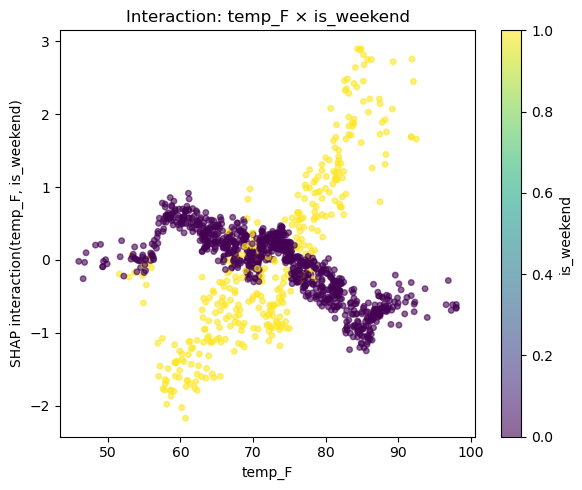

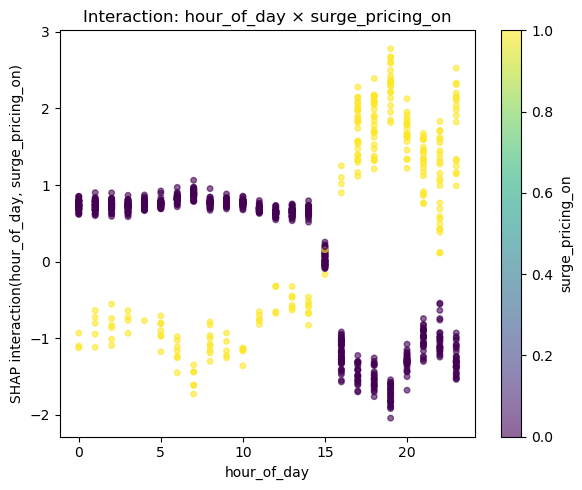

In [21]:
# =============================
# 7) VISUALIZE: CUSTOM DEPENDENCE SCATTERS (robust to SHAP plotting version issues)
# -----------------------------
# What: For a pair (i, j), plot feature i values on x, SHAP interaction(i,j) on y,
#       and color points by feature j to show conditional patterns—mimicking SHAP's dependence plot.
# Why: Avoids version conflicts in shap.dependence_plot while showing the same information.
# =============================
import matplotlib.pyplot as plt
import numpy as np

def plot_interaction_scatter(X_frame, iv_values, feat_x, feat_color, cmap_name="viridis"):
    i = X_frame.columns.get_loc(feat_x)
    j = X_frame.columns.get_loc(feat_color)
    x = X_frame[feat_x].values
    c = X_frame[feat_color].values
    y = iv_values[:, i, j]  # SHAP interaction term between i and j

    fig = plt.figure(figsize=(6,5))
    sc = plt.scatter(x, y, c=c, alpha=0.6, s=16, cmap=cmap_name)
    plt.xlabel(feat_x)
    plt.ylabel(f"SHAP interaction({feat_x}, {feat_color})")
    cb = plt.colorbar(sc)
    cb.set_label(feat_color)
    plt.title(f"Interaction: {feat_x} × {feat_color}")
    plt.tight_layout()
    plt.show()

# Plot two key pairs
plot_interaction_scatter(X, np.array(interaction_values), "temp_F", "is_weekend")
plot_interaction_scatter(X, np.array(interaction_values), "hour_of_day", "surge_pricing_on")


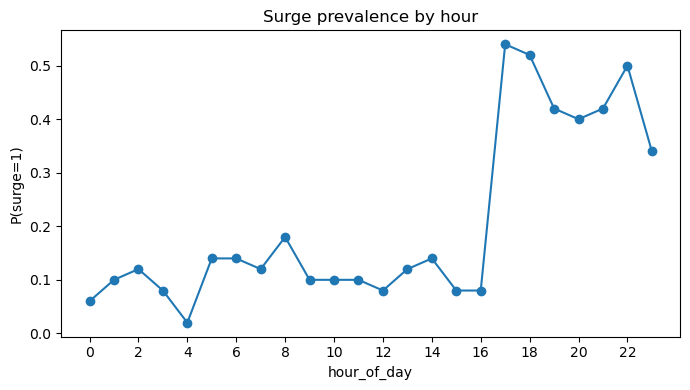

NameError: name 'rf' is not defined

<Figure size 600x400 with 0 Axes>

In [22]:
# 3) Prevalence by hour
prev = X.groupby("hour_of_day")["surge_pricing_on"].mean()
fig = plt.figure(figsize=(7,4))
plt.plot(prev.index, prev.values, marker="o")
plt.xticks(range(0,24,2)); plt.xlabel("hour_of_day"); plt.ylabel("P(surge=1)")
plt.title("Surge prevalence by hour"); plt.tight_layout(); plt.show()

# 4) PDP: surge only
fig = plt.figure(figsize=(6,4))
PartialDependenceDisplay.from_estimator(
    rf, X, features=["surge_pricing_on"], kind="average", grid_resolution=2
)
plt.title("PDP: surge_pricing_on (average effect)")
plt.tight_layout(); plt.show()

# 5) PDP: surge × hour_of_day
fig = plt.figure(figsize=(6,4))
PartialDependenceDisplay.from_estimator(
    rf, X, features=[("surge_pricing_on","hour_of_day")], kind="average", grid_resolution=24
)
plt.title("PDP: surge_pricing_on × hour_of_day")
plt.tight_layout(); plt.show()

# 6) Counterfactual flip: Δprediction when toggling surge, by hour
sample = X.sample(n=min(800, len(X)), random_state=1).copy()
base = rf.predict(sample)
flip = sample.copy(); flip["surge_pricing_on"] = 1 - flip["surge_pricing_on"]
flip_pred = rf.predict(flip)
delta = pd.Series(flip_pred - base, index=sample.index)
delta_by_hour = delta.groupby(sample["hour_of_day"]).mean()

fig = plt.figure(figsize=(7,4))
plt.bar(delta_by_hour.index, delta_by_hour.values)
plt.xlabel("hour_of_day"); plt.ylabel("Δ rides (flip surge)")
plt.title("Counterfactual: Avg Δ rides when toggling surge (by hour)")
plt.tight_layout(); plt.show()

delta_by_hour.head()

In [13]:
# =============================
# 8) QUICK, STAKEHOLDER-FRIENDLY TAKEAWAYS
# -----------------------------
# What: Turn numbers into 2–3 crisp bullets you can paste into your reply email or slide.
# Why: Communicate the "so what" from the SHAP interaction analysis.
# =============================
bullets = []

# 1) Warm weekends pop (use top_pairs and a simple conditional slice to illustrate)
wknd_mask = (X["is_weekend"] == 1) & (X["temp_F"] > 75)
weekday_mask = (X["is_weekend"] == 0) & (X["temp_F"] > 75)
wknd_effect = np.mean(np.array(interaction_values)[wknd_mask.values, X.columns.get_loc("temp_F"), X.columns.get_loc("is_weekend")])
weekday_effect = np.mean(np.array(interaction_values)[weekday_mask.values, X.columns.get_loc("temp_F"), X.columns.get_loc("is_weekend")])
bullets.append(f"Warm weekends: SHAP interaction(temp_F, is_weekend) is +{wknd_effect:.2f} on average vs {weekday_effect:.2f} on hot weekdays → weekend heat multiplies demand.")

# 2) Surge boosts evenings
eve_mask = (X["hour_of_day"] >= 17) & (X["surge_pricing_on"] == 1)
day_mask = (X["hour_of_day"] < 17) & (X["surge_pricing_on"] == 1)
eve_eff = np.mean(np.array(interaction_values)[eve_mask.values, X.columns.get_loc("hour_of_day"), X.columns.get_loc("surge_pricing_on")])
day_eff = np.mean(np.array(interaction_values)[day_mask.values, X.columns.get_loc("hour_of_day"), X.columns.get_loc("surge_pricing_on")])
bullets.append(f"Surge timing: Interaction(hour_of_day, surge_pricing_on) is +{eve_eff:.2f} after 5pm vs {day_eff:.2f} before 5pm → surge helps at commute hours.")

# 3) (Optional) Wind hurts most when cold — show sign
cold_mask = (X["temp_F"] < 55)
wind_int = np.mean(np.array(interaction_values)[cold_mask.values, X.columns.get_loc("wind_mph"), X.columns.get_loc("temp_F")])
bullets.append(f"Cold & windy: Interaction(wind_mph, temp_F) ≈ {wind_int:.2f} when temp_F<55 → wind penalties grow in cold conditions.")

print("\nTOP INTERACTION PAIRS (mean |interaction|):")
print(top_pairs_df.to_string(index=False))

print("\nSo-what bullets:")
for b in bullets:
    print("•", b)



TOP INTERACTION PAIRS (mean |interaction|):
   feature_i        feature_j  mean_abs_interaction
      temp_F      hour_of_day                 1.004
 hour_of_day surge_pricing_on                 0.957
      temp_F       is_weekend                 0.540
      temp_F         wind_mph                 0.525
      temp_F     humidity_pct                 0.503
humidity_pct         wind_mph                 0.457
  is_weekend      hour_of_day                 0.403
humidity_pct      hour_of_day                 0.393

So-what bullets:
• Warm weekends: SHAP interaction(temp_F, is_weekend) is +1.21 on average vs -0.48 on hot weekdays → weekend heat multiplies demand.
• Surge timing: Interaction(hour_of_day, surge_pricing_on) is +1.65 after 5pm vs -0.79 before 5pm → surge helps at commute hours.
• Cold & windy: Interaction(wind_mph, temp_F) ≈ -0.20 when temp_F<55 → wind penalties grow in cold conditions.
